In [47]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [48]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Constants


In [49]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
EPOCHS = 30
DROPOUT = 0.5

## Data Pre-processing


In [50]:
img_gen_train = ImageDataGenerator(
    brightness_range=[0.4, 1.0],
    rotation_range=15,
    zoom_range=0.3,
    data_format="channels_last",
    horizontal_flip=True,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rescale=1.0 / 255,
)

training_generator = img_gen_train.flow_from_directory(
    directory="data/train",
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    color_mode="rgb",
    batch_size=64,
    class_mode="binary"
)


Found 3784 images belonging to 2 classes.


In [51]:
img_gen_val = ImageDataGenerator(
    rescale=1.0 / 255
)

validation_generator = img_gen_val.flow_from_directory(
    directory="data/val",
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode="binary",
    batch_size=64
)


Found 445 images belonging to 2 classes.


In [52]:
STEP_SIZE_TRAIN = training_generator.n//training_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

## Build Model


#### transfer learning with VGG16

In [53]:
model_input = tf.keras.Input(shape=training_generator.image_shape)
base_model = tf.keras.applications.MobileNetV2(include_top=False, input_tensor=model_input)
base_model.trainable = False
model = base_model.layers[-1].output
x = Flatten()(model)
x = Dense(256, activation="relu")(x)
x = Dropout(DROPOUT)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(DROPOUT)(x)
x = Dense(64, activation='relu')(x)
out = Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs=model_input, outputs=out)


#### CNN

In [54]:
# model_input = tf.keras.Input(shape=training_generator.image_shape)
# x = Conv2D(16, (7, 7), activation='relu', padding='same')(model_input)
# x = MaxPooling2D((3, 3))(x)
# x = BatchNormalization()(x)
# x = Conv2D(16, (5, 5), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.005))(x)
# x = MaxPooling2D((3, 3))(x)
# x = BatchNormalization()(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.005))(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.005))(x)
# x = MaxPooling2D((2, 2))(x)
# x = BatchNormalization()(x)
# x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.005))(x)
# x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.005))(x)
# x = MaxPooling2D((2, 2))(x)
# x = Flatten()(x)
# x = Dense(512, activation="relu")(x)
# x = Dropout(DROPOUT)(x)
# x = Dense(64, activation="relu")(x)
# out = Dense(1, activation="sigmoid")(x)
# model = tf.keras.Model(inputs=model_input, outputs=out)

In [55]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 32) 864         input_10[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 128, 128, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

## Train Model


In [56]:
hist = model.fit(training_generator,
                steps_per_epoch=STEP_SIZE_TRAIN, 
                epochs=EPOCHS, 
                validation_data=validation_generator,
                validation_steps=STEP_SIZE_VALID, 
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True), tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=5, restore_best_weights=True)],
                verbose=1)


d:\hotdog_no_hotdog\env\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
d:\hotdog_no_hotdog\env\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/30
59/59 [==============================] - 80s 1s/step - loss: 2.6528 - accuracy: 0.7027 - val_loss: 0.2874 - val_accuracy: 0.8958
Epoch 2/30
59/59 [==============================] - 77s 1s/step - loss: 0.4008 - accuracy: 0.8299 - val_loss: 0.2154 - val_accuracy: 0.9036
Epoch 3/30
59/59 [==============================] - 76s 1s/step - loss: 0.3122 - accuracy: 0.8751 - val_loss: 0.2324 - val_accuracy: 0.9062
Epoch 4/30
59/59 [==============================] - 76s 1s/step - loss: 0.3170 - accuracy: 0.8629 - val_loss: 0.2316 - val_accuracy: 0.8984
Epoch 5/30
59/59 [==============================] - 77s 1s/step - loss: 0.3095 - accuracy: 0.8773 - val_loss: 0.2601 - val_accuracy: 0.8958
Epoch 6/30
59/59 [==============================] - 77s 1s/step - loss: 0.2938 - accuracy: 0.8756 - val_loss: 0.2397 - val_accuracy: 0.9062
Epoch 7/30
59/59 [==============================] - 77s 1s/step - loss: 0.2898 - accuracy: 0.8675 - val_loss: 0.2773 - val_accuracy: 0.8932
Epoch 8/30
59/59 [==

## Learning Curve


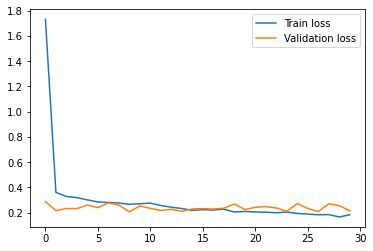

In [57]:
plt.plot(hist.history["loss"], label="Train loss")
plt.plot(hist.history["val_loss"], label="Validation loss")
plt.legend()

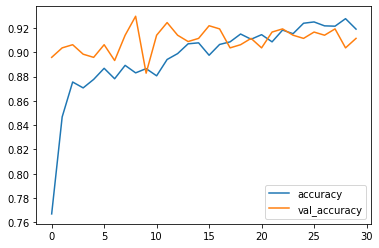

In [58]:
plt.plot(hist.history["accuracy"], label="accuracy")
plt.plot(hist.history["val_accuracy"], label="val_accuracy")
plt.legend()

## Making Predictions


In [59]:
test_data_generator = ImageDataGenerator(
    rescale=1.0 / 255
)

test_gen = test_data_generator.flow_from_directory(
    directory="data/test",
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode="binary",
    batch_size=1,
    shuffle=False
)


Found 224 images belonging to 2 classes.


In [60]:
test_gen.reset()
labels = test_gen.labels
labels = np.reshape(labels, (labels.shape[0], 1)).astype("float32")
filenames = np.array(test_gen.filenames)
filenames = np.reshape(filenames, (filenames.shape[0], 1))
preds = model.predict(test_gen)
preds[preds >= 0.5] = 1
preds[preds < 0.5] = 0
results = np.concatenate((filenames, labels), axis=1)
results = np.concatenate((results, preds), axis=1)


In [61]:
errors = np.sum(results[:, 1:2] != results[:, 2:3])
classification_acc = 1 - (errors / len(test_gen))
cm = confusion_matrix(results[:, 1:2].flatten(), results[:, 2:3].flatten())
print("Confusion Matrix:")
print(cm)
print(f'Total number of errors: {errors}')
print(f'The classification accuracy for the model is: {round(classification_acc,3) * 100} %')

Confusion Matrix:
[[110   7]
 [  5 102]]
Total number of errors: 12
The classification accuracy for the model is: 94.6 %


In [16]:

# predictions = model.predict(x_test)
# predictions[predictions >= 0.5] = 1
# predictions[predictions < 0.5] = 0
# errors = np.sum(y_test != predictions.flatten())
# classification_acc = 1 - (errors / len(y_test))
# cm = confusion_matrix(y_test, predictions)
# print("Confusion Matrix:")
# print(cm)
# print(f'Total number of errors: {errors}')
# print(f'The classification accuracy for the model is: {round(classification_acc,3) * 100} %')


## Save the model


In [62]:
# model.save("mobile_hotdog.h5")